In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate

import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50


Image_Size = [384, 1216]
Gradient_Clipping = 0.8


Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'unet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = True
checkpoint_dir = '../trained' + '_' + Model_Name
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)
dir_checkpoint = Path(checkpoint_dir)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 776.26it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    segnet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    enet_optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [unet_optimizer, segnet_optimizer, enet_optimizer]
    
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(enet_optimizer, 'max', patience=2)  # goal: maximize Dice score
        
else:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
    optims = [optimizer]
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
    
    
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss

def grad_forback(models, losses, optim):
    optim.zero_grad(set_to_none=True)
    grad_scaler.scale(losses).backward()
    torch.nn.utils.clip_grad_norm_(models.parameters(), Gradient_Clipping)
    grad_scaler.step(optim)
    grad_scaler.update()    

def forward_and_backward(model, images, true_masks, amp, optimizers, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        
        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels

        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
            
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
            
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)
    
    
    if model_name == 'ensemble_voting':
        for _loss, _optiz in zip([unet_loss, segnet_loss, enet_loss], optimizers):
            grad_forback(model, _loss, _optiz)

        return model, unet_loss, segnet_loss, enet_loss
    else:
        for _loss, _optiz in zip([loss], optimizers):
            grad_forback(model, _loss, _optiz)
            
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optims, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                #voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                print('---')
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:08<00:00, 43.85img/s]

***
unet Loss: 0.5407831072807312


Epoch 1/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.77img/s]


---
unet Validation Dice Loss: 1.4107210636138916
unet Validation Pixel Accuracy: 0.450653076171875
unet Validation MIoU: 0.2834143474316703
unet Validation Dice Score: 0.3806003928184509


Epoch 2/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.83img/s]

***
unet Loss: 0.5164741277694702


Epoch 2/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.17img/s]


---
unet Validation Dice Loss: 0.809211015701294
unet Validation Pixel Accuracy: 0.8724135014048794
unet Validation MIoU: 0.690871503375303
unet Validation Dice Score: 0.7377544045448303


Epoch 3/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.74img/s]

***
unet Loss: 0.4526466727256775


Epoch 3/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.68img/s]


---
unet Validation Dice Loss: 0.6065911650657654
unet Validation Pixel Accuracy: 0.9217435602556195
unet Validation MIoU: 0.776007135779289
unet Validation Dice Score: 0.7890467643737793


Epoch 4/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.86img/s]

***
unet Loss: 0.3475264310836792


Epoch 4/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.66img/s]


---
unet Validation Dice Loss: 0.4251253604888916
unet Validation Pixel Accuracy: 0.9343146608586896
unet Validation MIoU: 0.7833372446725047
unet Validation Dice Score: 0.8275594115257263


Epoch 5/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.86img/s]

***
unet Loss: 0.31702569127082825


Epoch 5/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.21img/s]


---
unet Validation Dice Loss: 0.4403960108757019
unet Validation Pixel Accuracy: 0.9382645456414473
unet Validation MIoU: 0.8093207431172849
unet Validation Dice Score: 0.8308984637260437


Epoch 6/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.69img/s]

***
unet Loss: 0.3113500475883484


Epoch 6/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.30img/s]


---
unet Validation Dice Loss: 0.42255496978759766
unet Validation Pixel Accuracy: 0.936160171241091
unet Validation MIoU: 0.80206005229038
unet Validation Dice Score: 0.8352531790733337


Epoch 7/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.08img/s]

***
unet Loss: 0.32607585191726685


Epoch 7/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.15img/s]


---
unet Validation Dice Loss: 0.3301255404949188
unet Validation Pixel Accuracy: 0.9467286227042215
unet Validation MIoU: 0.8305499567173066
unet Validation Dice Score: 0.8708080649375916


Epoch 8/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.81img/s]

***
unet Loss: 0.296148419380188


Epoch 8/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.89img/s]


---
unet Validation Dice Loss: 0.4919908940792084
unet Validation Pixel Accuracy: 0.9217098303008497
unet Validation MIoU: 0.7780294846019078
unet Validation Dice Score: 0.8122736215591431


Epoch 9/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.75img/s]

***
unet Loss: 0.2228412628173828


Epoch 9/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.05img/s]


---
unet Validation Dice Loss: 0.43719571828842163
unet Validation Pixel Accuracy: 0.9234581662897479
unet Validation MIoU: 0.7816914894903355
unet Validation Dice Score: 0.8289512991905212


Epoch 10/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.77img/s]

***
unet Loss: 0.19095993041992188


Epoch 10/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.94img/s]


---
unet Validation Dice Loss: 0.3899851143360138
unet Validation Pixel Accuracy: 0.9349153752912555
unet Validation MIoU: 0.8045294849706023
unet Validation Dice Score: 0.8384942412376404


Epoch 11/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.83img/s]

***
unet Loss: 0.18857765197753906


Epoch 11/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.97img/s]


---
unet Validation Dice Loss: 0.25800973176956177
unet Validation Pixel Accuracy: 0.9587889554207785
unet Validation MIoU: 0.8568843360041818
unet Validation Dice Score: 0.8858830332756042


Epoch 12/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.90img/s]

***
unet Loss: 0.2460526078939438


Epoch 12/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.33img/s]


---
unet Validation Dice Loss: 0.26218369603157043
unet Validation Pixel Accuracy: 0.9583373488041392
unet Validation MIoU: 0.8556133292784138
unet Validation Dice Score: 0.885633111000061


Epoch 13/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.67img/s]

***
unet Loss: 0.17972740530967712


Epoch 13/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.28img/s]


---
unet Validation Dice Loss: 0.25626140832901
unet Validation Pixel Accuracy: 0.9599938643606085
unet Validation MIoU: 0.8595529354485925
unet Validation Dice Score: 0.8929106593132019


Epoch 14/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.88img/s]

***
unet Loss: 0.1916528046131134


Epoch 14/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.00img/s]


---
unet Validation Dice Loss: 0.25553274154663086
unet Validation Pixel Accuracy: 0.960534882127193
unet Validation MIoU: 0.8629660911676984
unet Validation Dice Score: 0.896131157875061


Epoch 15/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.50img/s]

***
unet Loss: 0.16203343868255615


Epoch 15/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.30img/s]


---
unet Validation Dice Loss: 0.2625935971736908
unet Validation Pixel Accuracy: 0.9598640308045504
unet Validation MIoU: 0.8632226456618197
unet Validation Dice Score: 0.892314612865448


Epoch 16/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.59img/s]

***
unet Loss: 0.16967633366584778


Epoch 16/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.40img/s]


---
unet Validation Dice Loss: 0.2602660655975342
unet Validation Pixel Accuracy: 0.9598656369928729
unet Validation MIoU: 0.861963297283058
unet Validation Dice Score: 0.8957163095474243


Epoch 17/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.65img/s]

***
unet Loss: 0.18074603378772736


Epoch 17/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.03img/s]


---
unet Validation Dice Loss: 0.24669496715068817
unet Validation Pixel Accuracy: 0.9627926475123355
unet Validation MIoU: 0.8695936355410712
unet Validation Dice Score: 0.9004759192466736


Epoch 18/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.42img/s]

***
unet Loss: 0.16723816096782684


Epoch 18/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.81img/s]


---
unet Validation Dice Loss: 0.2501556873321533
unet Validation Pixel Accuracy: 0.9606762266995614
unet Validation MIoU: 0.8622407263430989
unet Validation Dice Score: 0.901091992855072


Epoch 19/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.51img/s]

***
unet Loss: 0.16800585389137268


Epoch 19/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.48img/s]


---
unet Validation Dice Loss: 0.2503889799118042
unet Validation Pixel Accuracy: 0.9602147152549342
unet Validation MIoU: 0.8607892919165052
unet Validation Dice Score: 0.8984628915786743


Epoch 20/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.38img/s]

***
unet Loss: 0.1531566083431244


Epoch 20/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.35img/s]


---
unet Validation Dice Loss: 0.2546900808811188
unet Validation Pixel Accuracy: 0.9593098958333334
unet Validation MIoU: 0.8593261652854833
unet Validation Dice Score: 0.9051824808120728


Epoch 21/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.51img/s]

***
unet Loss: 0.17208468914031982


Epoch 21/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.03img/s]


---
unet Validation Dice Loss: 0.24285520613193512
unet Validation Pixel Accuracy: 0.9625610886958608
unet Validation MIoU: 0.8681827384985261
unet Validation Dice Score: 0.8990726470947266


Epoch 22/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.40img/s]

***
unet Loss: 0.1554606705904007


Epoch 22/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.84img/s]


---
unet Validation Dice Loss: 0.24455632269382477
unet Validation Pixel Accuracy: 0.9628627844024122
unet Validation MIoU: 0.8701255245834986
unet Validation Dice Score: 0.8973323106765747


Epoch 23/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.42img/s]

***
unet Loss: 0.14809554815292358


Epoch 23/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.02img/s]


---
unet Validation Dice Loss: 0.25050055980682373
unet Validation Pixel Accuracy: 0.9601279810855263
unet Validation MIoU: 0.8623631218279246
unet Validation Dice Score: 0.9021186828613281


Epoch 24/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.69img/s]

***
unet Loss: 0.1367069035768509


Epoch 24/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.15img/s]


---
unet Validation Dice Loss: 0.2495259791612625
unet Validation Pixel Accuracy: 0.960270128752056
unet Validation MIoU: 0.8630826281250914
unet Validation Dice Score: 0.901923656463623


Epoch 25/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.47img/s]

***
unet Loss: 0.15140461921691895


Epoch 25/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.83img/s]


---
unet Validation Dice Loss: 0.24476689100265503
unet Validation Pixel Accuracy: 0.9618915758634868
unet Validation MIoU: 0.867589700612351
unet Validation Dice Score: 0.9030917286872864


Epoch 26/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.40img/s]

***
unet Loss: 0.14347012341022491


Epoch 26/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.91img/s]


---
unet Validation Dice Loss: 0.24842305481433868
unet Validation Pixel Accuracy: 0.9613270006681743
unet Validation MIoU: 0.8665633130010036
unet Validation Dice Score: 0.9020628929138184


Epoch 27/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.22img/s]

***
unet Loss: 0.14422929286956787


Epoch 27/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.76img/s]


---
unet Validation Dice Loss: 0.24532537162303925
unet Validation Pixel Accuracy: 0.9617355078981634
unet Validation MIoU: 0.8672593295473481
unet Validation Dice Score: 0.9024133086204529


Epoch 28/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.31img/s]

***
unet Loss: 0.14199744164943695


Epoch 28/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.89img/s]


---
unet Validation Dice Loss: 0.24576804041862488
unet Validation Pixel Accuracy: 0.9616560015762061
unet Validation MIoU: 0.8669542424227555
unet Validation Dice Score: 0.9032902717590332


Epoch 29/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.39img/s]

***
unet Loss: 0.13882127404212952


Epoch 29/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.82img/s]


---
unet Validation Dice Loss: 0.2406115084886551
unet Validation Pixel Accuracy: 0.9627096611156798
unet Validation MIoU: 0.8702198447025091
unet Validation Dice Score: 0.9027693867683411


Epoch 30/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.32img/s]

***
unet Loss: 0.16615040600299835


Epoch 30/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.84img/s]


---
unet Validation Dice Loss: 0.2459993064403534
unet Validation Pixel Accuracy: 0.961501539799205
unet Validation MIoU: 0.8667198240721953
unet Validation Dice Score: 0.9030798077583313


Epoch 31/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.31img/s]

***
unet Loss: 0.16412502527236938


Epoch 31/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.95img/s]


---
unet Validation Dice Loss: 0.2457447201013565
unet Validation Pixel Accuracy: 0.961672866553591
unet Validation MIoU: 0.8671474348806676
unet Validation Dice Score: 0.903154194355011


Epoch 32/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.51img/s]

***
unet Loss: 0.14241714775562286


Epoch 32/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.90img/s]


---
unet Validation Dice Loss: 0.2428627759218216
unet Validation Pixel Accuracy: 0.9621110882675439
unet Validation MIoU: 0.8683043408195246
unet Validation Dice Score: 0.9026848673820496


Epoch 33/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.57img/s]

***
unet Loss: 0.17189233005046844


Epoch 33/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.89img/s]


---
unet Validation Dice Loss: 0.24516510963439941
unet Validation Pixel Accuracy: 0.9617325632195723
unet Validation MIoU: 0.8674113792281091
unet Validation Dice Score: 0.9027457237243652


Epoch 34/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.58img/s]

***
unet Loss: 0.16646809875965118


Epoch 34/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.99img/s]


---
unet Validation Dice Loss: 0.25069528818130493
unet Validation Pixel Accuracy: 0.9610247695655153
unet Validation MIoU: 0.8658745205349031
unet Validation Dice Score: 0.9019560217857361


Epoch 35/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.16img/s]

***
unet Loss: 0.14717069268226624


Epoch 35/50:  99%|█████████▊| 200/203 [00:08<00:00, 23.03img/s]


---
unet Validation Dice Loss: 0.24711407721042633
unet Validation Pixel Accuracy: 0.961251509817023
unet Validation MIoU: 0.8656469248966725
unet Validation Dice Score: 0.9033681154251099


Epoch 36/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.30img/s]

***
unet Loss: 0.14150550961494446


Epoch 36/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.99img/s]


---
unet Validation Dice Loss: 0.24770687520503998
unet Validation Pixel Accuracy: 0.961218047560307
unet Validation MIoU: 0.8658234151530059
unet Validation Dice Score: 0.9020559191703796


Epoch 37/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.56img/s]

***
unet Loss: 0.16809791326522827


Epoch 37/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.74img/s]


---
unet Validation Dice Loss: 0.24660982191562653
unet Validation Pixel Accuracy: 0.961600052682977
unet Validation MIoU: 0.867032404788816
unet Validation Dice Score: 0.9024187326431274


Epoch 38/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.67img/s]

***
unet Loss: 0.14776194095611572


Epoch 38/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.65img/s]


---
unet Validation Dice Loss: 0.24594241380691528
unet Validation Pixel Accuracy: 0.961501539799205
unet Validation MIoU: 0.8665566522893609
unet Validation Dice Score: 0.9033425450325012


Epoch 39/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.39img/s]

***
unet Loss: 0.15742723643779755


Epoch 39/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.51img/s]


---
unet Validation Dice Loss: 0.24327294528484344
unet Validation Pixel Accuracy: 0.9621603447094298
unet Validation MIoU: 0.8686032123386267
unet Validation Dice Score: 0.9033752679824829


Epoch 40/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.72img/s]

***
unet Loss: 0.153489887714386


Epoch 40/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.57img/s]


---
unet Validation Dice Loss: 0.2489653080701828
unet Validation Pixel Accuracy: 0.9609535618832237
unet Validation MIoU: 0.8650319414636665
unet Validation Dice Score: 0.9032630324363708


Epoch 41/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.49img/s]

***
unet Loss: 0.14718791842460632


Epoch 41/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.94img/s]


---
unet Validation Dice Loss: 0.24749866127967834
unet Validation Pixel Accuracy: 0.9613802725808662
unet Validation MIoU: 0.8662464774403442
unet Validation Dice Score: 0.903233528137207


Epoch 42/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.37img/s]

***
unet Loss: 0.1510586142539978


Epoch 42/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.79img/s]


---
unet Validation Dice Loss: 0.24693210422992706
unet Validation Pixel Accuracy: 0.9615055552700109
unet Validation MIoU: 0.8669888354225078
unet Validation Dice Score: 0.9019855856895447


Epoch 43/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.16img/s]

***
unet Loss: 0.21831832826137543


Epoch 43/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.92img/s]


---
unet Validation Dice Loss: 0.2429312765598297
unet Validation Pixel Accuracy: 0.9619253058182565
unet Validation MIoU: 0.8678837899216636
unet Validation Dice Score: 0.9025675654411316


Epoch 44/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.45img/s]

***
unet Loss: 0.15421918034553528


Epoch 44/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.74img/s]


---
unet Validation Dice Loss: 0.24448618292808533
unet Validation Pixel Accuracy: 0.961578369140625
unet Validation MIoU: 0.8669118500572572
unet Validation Dice Score: 0.9030136466026306


Epoch 45/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.35img/s]

***
unet Loss: 0.169804185628891


Epoch 45/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.69img/s]


---
unet Validation Dice Loss: 0.24933911859989166
unet Validation Pixel Accuracy: 0.9609701591625548
unet Validation MIoU: 0.8652143757055493
unet Validation Dice Score: 0.9028427004814148


Epoch 46/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.68img/s]

***
unet Loss: 0.15157687664031982


Epoch 46/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.78img/s]


---
unet Validation Dice Loss: 0.24707376956939697
unet Validation Pixel Accuracy: 0.9614940442537007
unet Validation MIoU: 0.8670607555003482
unet Validation Dice Score: 0.9029823541641235


Epoch 47/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.32img/s]

***
unet Loss: 0.14087985455989838


Epoch 47/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.41img/s]


---
unet Validation Dice Loss: 0.24773086607456207
unet Validation Pixel Accuracy: 0.9611883330763432
unet Validation MIoU: 0.8654559887985644
unet Validation Dice Score: 0.9030205011367798


Epoch 48/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.49img/s]

***
unet Loss: 0.14069631695747375


Epoch 48/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.77img/s]


---
unet Validation Dice Loss: 0.24441097676753998
unet Validation Pixel Accuracy: 0.9617146274499726
unet Validation MIoU: 0.8668376475454935
unet Validation Dice Score: 0.903409481048584


Epoch 49/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.65img/s]

***
unet Loss: 0.16444817185401917


Epoch 49/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.97img/s]


---
unet Validation Dice Loss: 0.25003182888031006
unet Validation Pixel Accuracy: 0.9611428244072094
unet Validation MIoU: 0.866274931805681
unet Validation Dice Score: 0.9019777178764343


Epoch 50/50:  99%|█████████▊| 200/203 [00:06<00:00, 43.66img/s]

***
unet Loss: 0.14653554558753967


Epoch 50/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.46img/s]

---
unet Validation Dice Loss: 0.24922680854797363
unet Validation Pixel Accuracy: 0.9609629313151041
unet Validation MIoU: 0.865265331240779
unet Validation Dice Score: 0.9025636911392212


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']
df.to_csv(checkpoint_dir + '/model_check.csv', encoding = 'UTF-8')

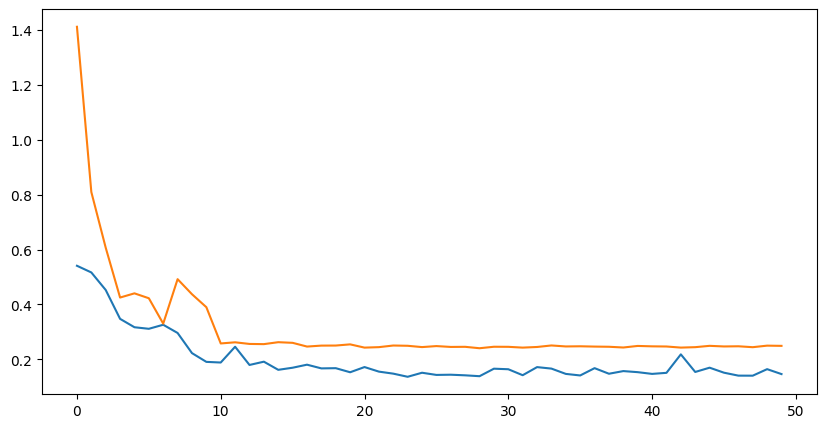

In [19]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

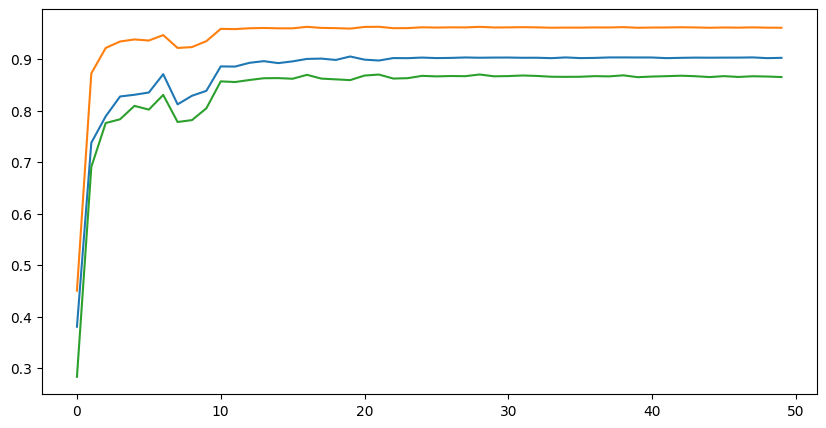

In [20]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)